In [ ]:
#speaches downloaded from https://www.bis.org/cbspeeches/download.htm

In [1]:
import pandas as pd
import numpy as np
from gensim.models import Word2Vec
from keras.preprocessing.text import Tokenizer
from sklearn.model_selection import train_test_split, GridSearchCV
from pandas.api.types import is_string_dtype, CategoricalDtype
#from keras.preprocessing.sequence import pad_sequences
#authors note, different version of Keras put pad_sequences in different places, if one doesn't work, please try the other
from keras.models import Sequential
from keras.layers import Dense, LSTM, Embedding, Dropout
from keras.utils.data_utils import pad_sequences
from scikeras.wrappers import KerasRegressor
from keras.callbacks import EarlyStopping
from keras.optimizers import Adam

In [2]:
import nltk
nltk.download('stopwords')
from nltk.corpus import stopwords

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\USER\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [3]:
regimes = pd.read_parquet('quarterly_data/df_2020Q1.parquet')
regimes['labels']

usa            0
canada         0
europe         2
uk             0
australia      0
brazil         1
india          1
switzerland    2
japan          2
south korea    0
Name: labels, dtype: int32

In [4]:
countries = regimes[regimes['labels'] == 0].index.tolist()

In [5]:
import re

dfs = []

# Iterate over the countries
for country in countries:
    # Read the Parquet file into a DataFrame
    if country == 'uk':
        country = 'england'
    if country == 'south korea':
        country = 'korea'
    df = pd.read_parquet(f"fed_statements/{country}.parquet")
    df = df.map(lambda x: re.sub(r'[^a-zA-Z0-9\s]|[\n]', '', str(x)) if isinstance(x, str) else x)
    
    # Add the DataFrame to the list
    dfs.append(df)

# Concatenate all the DataFrames along the row axis
data = pd.concat(dfs, axis=0)

In [6]:
data = data.sort_index(ascending=True)

In [7]:
from datetime import datetime, timedelta, time

# Create a copy of your DataFrame to avoid modifying the original data
data_adjusted = data.copy()

# Group by date and check for multiple entries per day
counts = data_adjusted.groupby(data_adjusted.index.normalize()).count()

# Get dates with more than one entry
duplicate_dates = counts[counts > 1].index

# Loop over duplicate dates and adjust the timestamps
for date in duplicate_dates:
    # Get the entries for this date
    entries = data_adjusted[data_adjusted.index.normalize() == date]
    
    # Generate new timestamps by adding a day for each subsequent entry
    new_timestamps = [pd.Timestamp(date + timedelta(days=i)) for i in range(len(entries))]
    
    # Update the index for the entries of this date
    data_adjusted.loc[data_adjusted.index.normalize() == date, 'index'] = new_timestamps

# Set the new index
data_adjusted.set_index('index', inplace=True)

In [8]:
target = pd.read_parquet("data/bonds.parquet")

In [9]:
target_resampled = target['usa'].diff().resample('D').interpolate(method='polynomial', order=2)
# Shift the DataFrame so we are predicting out in time
target_shifted = target_resampled.shift(30)

In [10]:
data_adjusted = data_adjusted.loc[~data_adjusted.index.duplicated(keep='first')]
data_adjusted.shape

(97, 1)

In [11]:
print(target_shifted.index.duplicated().sum())
print(data_adjusted.index.duplicated().sum())

0
0


In [12]:
# Get the common indices
common_indices = target_shifted.index.intersection(data_adjusted.index)

# Select the data from target_shifted and data_adjusted where the index is in common_indices
target_shifted = target_shifted.loc[common_indices]
data_adjusted = data_adjusted.loc[common_indices]

In [13]:
data_adjusted['content'] = data_adjusted['content'].apply(lambda x: x.split())

# Convert the column of lists into a single list of sentences
sentences = data_adjusted['content'].tolist()


train word vectors

In [14]:
# Word2Vec
word2vec = Word2Vec(sentences, vector_size=120, window=5, min_count=1, workers=4)
word2vec.train(sentences, total_examples=len(sentences), epochs=10)

(2414530, 3311850)

Create target column

In [15]:
# Word2Vec => tokenize my words to prep for LSTM
tokenizer = Tokenizer()
tokenizer.fit_on_texts(sentences)
sequences = tokenizer.texts_to_sequences(sentences)
data = pad_sequences(sequences)

# Prepare target variable (freedom scores)
# ... (your code here)
print(data.shape)
print(target_shifted.shape)

(93, 23489)
(93,)


In [16]:
def expand_features(full_array, window=5):

    n_features = full_array.shape[1]
    

    expanded_features = np.zeros((full_array.shape[0], n_features * window))
    for feature_idx in range(n_features):
        # For each time step in the window
        for lag in range(window):
            # Shift the data
            shifted_data = np.roll(full_array[:, feature_idx], lag)
            # Set the first 'lag' values to zero
            shifted_data[:lag] = 0
            # Store it in the expanded features
            expanded_features[:, feature_idx*window + lag] = shifted_data
            
    return expanded_features

In [17]:
expanded_data = expand_features(data, 5)

In [18]:
X_train, X_test, y_train, y_test = train_test_split(expanded_data, target_shifted, test_size=0.2, random_state=42, shuffle=False)

Find word similarities

In [19]:
word_vectors = word2vec.wv.vectors
# Create a word-to-index dictionary
word_to_index = {word: i for i, word in enumerate(word2vec.wv.index_to_key)}

# Create an embedding matrix
embedding_matrix = np.zeros((len(word_to_index) + 1, word2vec.vector_size))
for word, i in word_to_index.items():
    embedding_matrix[i] = word2vec.wv[word]



In [20]:
from tensorflow.keras.layers import Bidirectional
# Define LSTM model
model = Sequential()
model.add(Embedding(input_dim=len(word_to_index) + 1, output_dim=word2vec.vector_size, weights=[embedding_matrix]))
model.add(Bidirectional(LSTM(units=64, return_sequences=True, activation='tanh')))  # More units, return sequences for stacking
model.add(Dropout(.2))  # Dropout for regularization
model.add(Bidirectional(LSTM(units=32, return_sequences=True, activation='tanh')))  # More units, return sequences for stacking
model.add(Dropout(.2))  # Dropout for regularization
model.add(Dense(1, activation='linear'))
# Compile the model with gradient clipping
opt = Adam(clipvalue=0.5)
model.compile(optimizer=opt, loss='mean_squared_error')

In [21]:
early_stopping = EarlyStopping(monitor='val_loss', patience=3)

history = model.fit(expanded_data, target_shifted, epochs=5, validation_split=0.2, batch_size=128, verbose=1)

Epoch 1/5


In [ ]:
import matplotlib.pyplot as plt
preds = model.predict(X_test)

# Create a range of numbers for your X axis
x_axis = range(len(preds))
#x_axis = X_test.index
# Plot the predictions along with the true values
plt.figure(figsize=(14, 5))
plt.plot(x_axis, preds, 'r', label='Predicted Values')
plt.plot(x_axis, y_test, 'b', label='Actual Values')
plt.title('predictions for differenced 10 yr bonds one month from previous fed meeting ')
plt.legend()
plt.show()

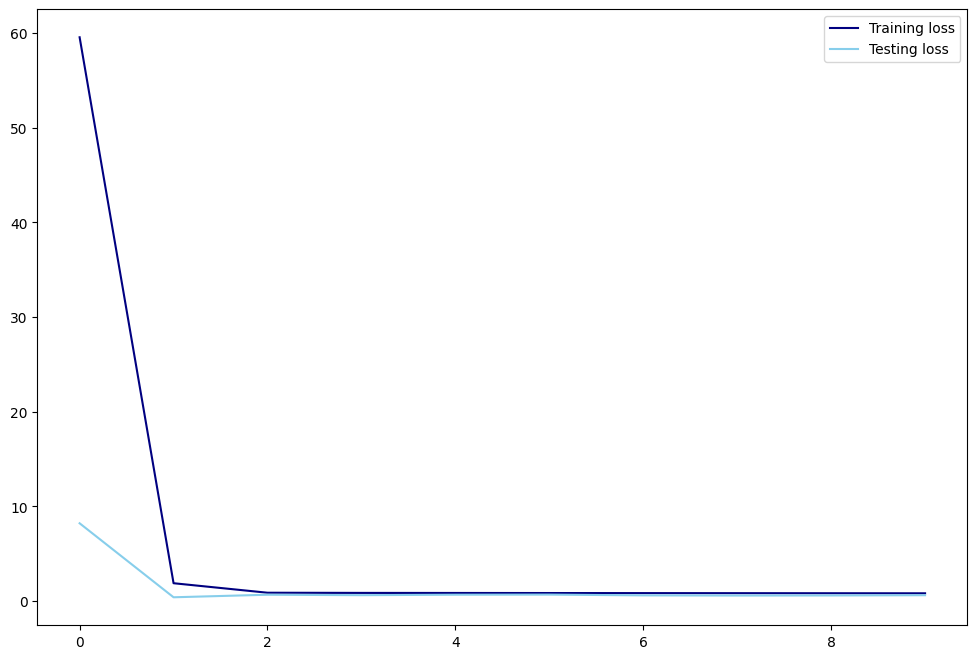

In [ ]:
# Visualize the loss
train_loss = history.history['loss']
test_loss = history.history['val_loss']

plt.figure(figsize=(12, 8))
plt.plot(train_loss, label='Training loss', color='navy')
plt.plot(test_loss, label='Testing loss', color='skyblue')
plt.legend();

In [ ]:
# Get the embeddings from the embedding layer
embeddings = model.layers[0].get_weights()[0]

# Create a dictionary to map indices to words
word_to_index = tokenizer.word_index
index_to_word = {v: k for k, v in word_to_index.items()}

# Now you can get the embedding of a word like this:
word = "example"
word_embedding = embeddings[word_to_index[word]]

In [ ]:
word_embedding

array([-0.02270818,  0.04638885, -0.00918608,  0.01880567,  0.02911003,
        0.00385864,  0.04770538, -0.01647489,  0.03811292, -0.04402161,
        0.00353162, -0.02625338, -0.04556441, -0.02418173,  0.03292876,
       -0.01646582,  0.02826924, -0.02207358, -0.04334329, -0.01394787,
        0.00198222, -0.01082713,  0.03528147,  0.02123004, -0.02284766,
        0.02744615,  0.04507652,  0.02539293, -0.00047426, -0.00055699,
       -0.04064018, -0.03228501, -0.0488784 ,  0.02343431, -0.00450666,
        0.01546543,  0.02649575, -0.03827449,  0.01888963,  0.0263534 ,
        0.02175152,  0.01311486,  0.03050259,  0.01900692,  0.0045494 ,
        0.02324464,  0.03395399,  0.01961519, -0.02793471,  0.00659522,
        0.04125473, -0.04515826,  0.01943357, -0.01864521, -0.02914256,
       -0.01288458,  0.03055224,  0.03107135,  0.00040753, -0.01992688,
        0.02807276,  0.0238966 , -0.03495276, -0.01783298,  0.00265012,
        0.0165749 ,  0.00904882, -0.03521918,  0.01849625, -0.02